In [1]:
import torch
import json
from pathlib import Path
import numpy as np
from src.common.evaluation import METRIC_WEIGHTS
import matplotlib.pyplot as plt
import seaborn as sns
import torch
sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
sns.set_palette("colorblind")
# cnndm
dataset_name = 'cnndm'
set_name = 'test'
generation_methods=['diverse_beam_search', 'beam_search']
models = ['pegasus_cnndm']
metrics = ['rouge1', 'rouge2', 'rougeLsum']
tradeoff_metric = 'rouge2'
# commongen
# dataset_name = 'commongen'
# set_name = 'val'
# generation_methods=['diverse_beam_search', 'beam_search']
# models = ['t5_common_gen']
# metrics = ['bleu', 'cider']
# tradeoff_metric = 'cider'
# # wmt18
# dataset_name = 'wmt18'
# set_name = 'test'
# generation_methods=['diverse_beam_search', 'beam_search']
# models = ['opus_mt']
# metrics = ['bleu']
# tradeoff_metric = 'bleu'

with open(f"./data/prepared/{dataset_name}/{set_name}/dataset.jsonl", "r") as f:
    data = [json.loads(line) for line in f]
for item in data:
    item['candidates'] = [c for c in item['candidates'] if c['model'] in models]
    item['candidates'] = [c for c in item['candidates'] if c['generation_method'] in generation_methods]
    for candidate in item['candidates']:
        candidate['scores'] = {
            metric: candidate['scores'][metric] for metric in metrics
        }
backbone = "microsoft/deberta-v3-large"
# backbone = "roberta-large"
checkpoint_path = Path(f"./outputs/crosscompare/{backbone}/train_{dataset_name}_full_comparison/")
SR_checkpoint_path = Path(f"./outputs/scr/{backbone}/train_{dataset_name}_SummaReranker/")
predictions = torch.load(checkpoint_path / "predictions.pt")
labels = torch.load(checkpoint_path / "labels.pt")
SR_predictions = torch.load(SR_checkpoint_path / "predictions.pt")
SR_labels = torch.load(SR_checkpoint_path / "labels.pt")
scores = np.array([[list(c['scores'].values()) for c in item['candidates']] for item in data])
# readjust the weight of the labels so that it's the same with scores
for i, metric in enumerate(metrics):
    labels[:, :, i] = labels[:, :, i] / METRIC_WEIGHTS[metric]
    SR_labels[:, :, i] = SR_labels[:, :, i] / METRIC_WEIGHTS[metric]
if np.abs((scores - labels)).mean() < 1e-5:
    print("dataset score consistent with PairReranker labels")
else:
    print(np.abs((scores - labels)).mean())
if np.abs((scores - SR_labels)).mean() < 1e-5:
    print("dataset score consistent with SummaReranker labels")
else:
    print(np.abs((scores - SR_labels)).mean())
# get the ranks
ranks = np.flip(np.argsort(scores, axis=1), axis=1)
values = np.arange(ranks.shape[1]).reshape(1, -1, 1).repeat(ranks.shape[0], axis=0).repeat(ranks.shape[2], axis=2)
np.put_along_axis(ranks, ranks.copy(), values, axis=1)

/home/dongfu/.conda/envs/dualfid/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dataset score consistent with PairReranker labels
dataset score consistent with SummaReranker labels


528
4 3
0.8


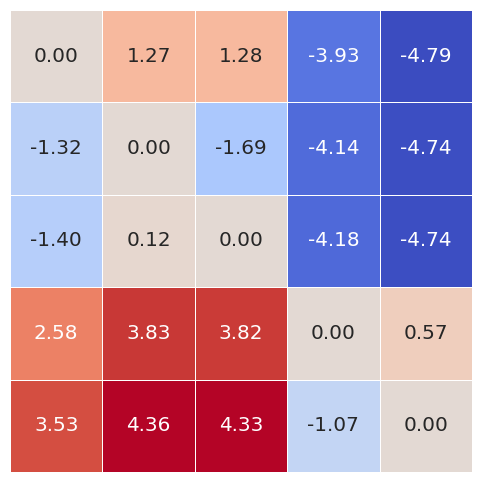

In [6]:
# heatmap
"""
7176
8542 is good
528
"""
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
sns.set_theme(font='Times New Roman', style='whitegrid')
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
sns.set_palette("colorblind")
n_candidates = 5
full_cmp_results = predictions[0]
batch_size = full_cmp_results.shape[0]
selected_bz_idxs = []
consistencies = []
for bz in range(batch_size):
    cur_cmp_results = full_cmp_results[bz, :n_candidates, :n_candidates]
    full_best_idx = (cur_cmp_results.mean(axis=1) - cur_cmp_results.mean(axis=0)).argmax(0)
    max_wins_position_best_idx = ((cur_cmp_results > 0).mean(axis=1) + (cur_cmp_results < 0).mean(axis=0)).argmax(0)
    idxs = [
        full_best_idx,
        max_wins_position_best_idx,
    ]
    if len(set(idxs)) == len(idxs):
        selected_bz_idxs.append(bz)
        consistencies.append((cur_cmp_results.T * cur_cmp_results < 0).mean())
# selected_bz_idx = selected_bz_idxs[np.argmax(consistencies)]
# selected_bz_idx = np.random.choice(selected_bz_idxs)
selected_bz_idx=528
data = predictions[0][selected_bz_idx, :n_candidates, :n_candidates]
full_best_idx = (data.mean(axis=1) - data.mean(axis=0)).argmax(0)
max_wins_position_best_idx = ((data > 0).mean(axis=1) + (data < 0).mean(axis=0)).argmax(0)
print(selected_bz_idx)
print(full_best_idx, max_wins_position_best_idx)
# tanh
print((data.T * data < 0).mean())
data = [[round(d, 2) for d in row] for row in data]

ax = sns.heatmap(data, annot=True, fmt=".2f", cmap="coolwarm", cbar=False, square=True, linewidths=0.5)
ax.figure.set_size_inches(7.5, 6)
ax.set_xticklabels([f"" for i in range(n_candidates)], fontsize=25)
ax.set_yticklabels([f"" for i in range(n_candidates)], fontsize=25)
plt.savefig("./pics/matrix_heatmap.pdf", dpi=100, format='pdf')
plt.savefig("./pics/matrix_heatmap.svg", dpi=100, format='svg')

In [ ]:
"""
use the merged beam order from diverse beam search and beams search as the inital order for comparison
"""
# Pairreranker full comparison
m = 1
full_cmp_results = predictions[0]
batch_size, n_candidates, n_candidates = full_cmp_results.shape
best_idx = []
for bz in range(batch_size):
    # interleavingly merge the beam order from diverse beam search and beam search
    merged_cands_idx = []
    cands_idx_per_decoding_method = {
        method: [i for i, c in enumerate(data[bz]['candidates']) if c['generation_method'] == method] for method in generation_methods
    }
    for i in range(n_candidates // len(generation_methods)):
        for method in generation_methods:
            merged_cands_idx.append(cands_idx_per_decoding_method[method][i])
    merged_cands_idx = merged_cands_idx[::-1]

    # multiple time of bubble sort
    bubble_best_idx = {}
    for _ in range(m):
        # do the bubble sort
        cur_best_idx = merged_cands_idx[0]
        for i in range(1, n_candidates):
            # confidence = full_cmp_results[bz, cur_best_idx, merged_cands_idx[i]] - full_cmp_results[bz, merged_cands_idx[i], cur_best_idx]
            confidence = - full_cmp_results[bz, merged_cands_idx[i], cur_best_idx]
            cur_best_idx = cur_best_idx if confidence > 0 else merged_cands_idx[i]        
        bubble_best_idx[cur_best_idx] = bubble_best_idx.get(cur_best_idx, 0) + 1
    best_idx.append(max(bubble_best_idx, key=bubble_best_idx.get))
best_scores = scores[np.arange(len(best_idx)), best_idx]
best_ranks = ranks[np.arange(len(best_idx)), best_idx]
mean_scores = best_scores.mean(axis=0)
mean_ranks = best_ranks.mean(axis=0)
print("Pairreranker bubble sort results (in merge decoding method beam score order)")
for metric, mean_score, mean_rank in zip(metrics, mean_scores, mean_ranks):
    print(metric, mean_score, mean_rank)


In [24]:
"""
Pairreranker performance & efficiency tradeoff
"""
# Pairreranker full comparison
full_cmp_results = predictions[0]
batch_size, n_candidates, n_candidates = full_cmp_results.shape
np.random.seed(42)
x = {}
y = {}

"""1. mutliple times of infernece with full comparison"""
m = 900
m = min(m, n_candidates ** 2)
full_best_idxs = [[] for _ in range(m)]
max_wins_best_idxs = [[] for _ in range(m)]
for bz in range(batch_size):
    # multiple time of bubble sort
    searched_full_cmp_results = np.zeros((n_candidates, n_candidates))
    to_score_pair_idx = [(i,j) for i in range(n_candidates) for j in range(n_candidates)]
    for _m in range(m):
        # add informaion
        pair_random_idx = np.random.choice(len(to_score_pair_idx))
        i,j = to_score_pair_idx[pair_random_idx]
        searched_full_cmp_results[i, j] = full_cmp_results[bz, i, j]
        # remove the pair
        to_score_pair_idx.pop(pair_random_idx)
        # get the best idx
        full_best_idx = (searched_full_cmp_results.mean(axis=1) - searched_full_cmp_results.mean(axis=0)).argmax()
        max_wins_best_idx = (searched_full_cmp_results > 0).mean(axis=1).argmax()
        full_best_idxs[_m].append(full_best_idx)
        max_wins_best_idxs[_m].append(max_wins_best_idx)

for label in ["full", "max_wins"]:
    x[label] = [i + 1 for i in range(m)]
    y[label] = []
    for best_idx in eval(label + "_best_idxs"):
        best_scores = scores[np.arange(len(best_idx)), best_idx]
        best_ranks = ranks[np.arange(len(best_idx)), best_idx]
        mean_scores = best_scores.mean(axis=0)
        y[label].append(mean_scores[metrics.index(tradeoff_metric)])
    x[label] = x[label][n_candidates:]
    y[label] = y[label][n_candidates:]

"""2. Multiple times of bubble run"""
num_bubble_runs = n_candidates
bubble_best_idxs = [[] for _ in range(num_bubble_runs)]
for bz in range(batch_size):
    _best_idx_count = {}
    for run in range(num_bubble_runs):
        random_idx = np.random.permutation(n_candidates)
        cur_best_idx = random_idx[-1]
        for i in range(1, n_candidates):
            confidence = full_cmp_results[bz, cur_best_idx, random_idx[i]]
            cur_best_idx = cur_best_idx if confidence > 0 else random_idx[i]
        _best_idx_count[cur_best_idx] = _best_idx_count.get(cur_best_idx, 0) + 1
        bubble_best_idxs[run].append(max(_best_idx_count, key=_best_idx_count.get))

x['bubble'] = [(i+1) * n_candidates for i in range(num_bubble_runs)]
y['bubble'] = []
for best_idx in bubble_best_idxs:
    best_scores = scores[np.arange(len(best_idx)), best_idx]
    best_ranks = ranks[np.arange(len(best_idx)), best_idx]
    mean_scores = best_scores.mean(axis=0)
    y['bubble'].append(mean_scores[metrics.index(tradeoff_metric)])

import pickle
pickle.dump(x, open(f"{dataset_name}_tradeoff_x_{tradeoff_metric}.pkl", "wb"))
pickle.dump(y, open(f"{dataset_name}_tradeoff_y_{tradeoff_metric}.pkl", "wb"))

In [8]:
# Pairreranker full comparison
full_cmp_results = predictions[0]
# full_cmp_results = torch.tanh(torch.tensor(full_cmp_results)).numpy()
# best_idx = full_cmp_results.sum(axis=-1).argmax(-1) # pre-position comparison
# best_idx = full_cmp_results.sum(axis=1).argmin(-1) # post-position comparison
best_idx = (full_cmp_results.sum(axis=-1) - full_cmp_results.sum(axis=1)).argmax(-1) # pre-post-position comparison
# best_idx = ((full_cmp_results > 0).sum(axis=-1) + (full_cmp_results < 0).sum(axis=-2)).argmax(-1) # most wins
best_scores = scores[np.arange(len(best_idx)), best_idx]
best_ranks = ranks[np.arange(len(best_idx)), best_idx]
mean_scores = best_scores.mean(axis=0)
mean_ranks = best_ranks.mean(axis=0)
print("Pairreranker full comparison results")
for metric, mean_score, mean_rank in zip(metrics, mean_scores, mean_ranks):
    print(metric, mean_score, mean_rank)


Pairreranker full comparison results
bleu 15.40852241957184 10.444001991040318
cider 15.86498928562489 10.301642608262817


In [3]:
# SummaReranker
SR_best_idx = SR_predictions.argmax(-1)
SR_best_scores = scores[np.arange(len(SR_best_idx)), SR_best_idx]
SR_best_ranks = ranks[np.arange(len(SR_best_idx)), SR_best_idx]
SR_mean_scores = SR_best_scores.mean(axis=0)
SR_mean_ranks = SR_best_ranks.mean(axis=0)
print("SummaReranker Comparison results")
for metric, mean_score, mean_rank in zip(metrics, SR_mean_scores, SR_mean_ranks):
    print(metric, mean_score, mean_rank)

SummaReranker Comparison results
rouge1 0.47211938581013563 10.001218450826807
rouge2 0.22838858151595912 11.034812880765884
rougeLsum 0.43993631957664564 10.28616187989556


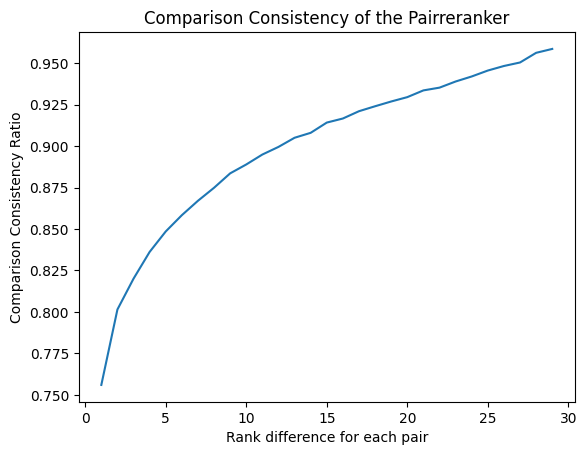

In [4]:
"""Ranks consistency analysis"""
full_cmp_results = predictions[0]
batch_size, n_candidates, n_candidates = full_cmp_results.shape
count1 = 0
count2 = 0
rank_consistency = {rank: [0, 0] for rank in range(1, n_candidates)}
for bz in range(batch_size):
    mean_scores = scores[bz].mean(axis=-1)
    _ranks = np.argsort(mean_scores)
    np.put_along_axis(_ranks, _ranks.copy(), np.arange(n_candidates), axis=0)
    for i in range(n_candidates):
        for j in range(n_candidates):
            if i == j:
                continue
            if full_cmp_results[bz, i, j] * full_cmp_results[bz, j, i] < 0:
                rank_consistency[abs(_ranks[i] - _ranks[j])][0] += 1
            rank_consistency[abs(_ranks[i] - _ranks[j])][1] += 1

# for rank, (count, total) in rank_consistency.items():
#     print(rank, count, total, count/total)

x = [rank for rank in rank_consistency]
y = [rank_consistency[rank][0]/rank_consistency[rank][1] for rank in rank_consistency]
import matplotlib.pyplot as plt
plt.xlabel("Rank difference for each pair")
plt.ylabel("Comparison Consistency Ratio")
plt.title("Comparison Consistency of the Pairreranker")
plt.plot(x, y)

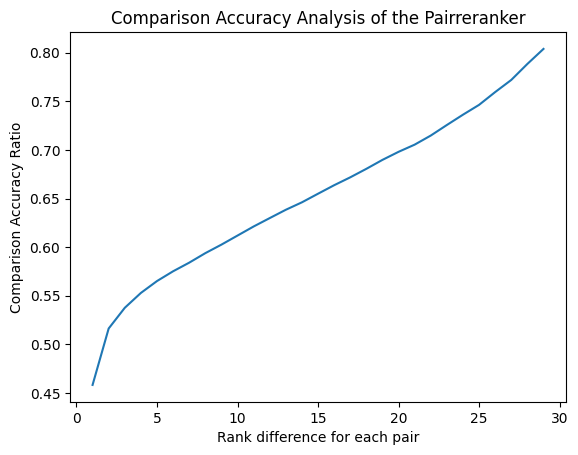

In [7]:
"""Ranks accuracy analysis"""
full_cmp_results = predictions[0]
batch_size, n_candidates, n_candidates = full_cmp_results.shape
count1 = 0
count2 = 0
rank_accuracy = {rank: [0, 0] for rank in range(1, n_candidates)}
for bz in range(batch_size):
    mean_scores = scores[bz].mean(axis=-1)
    _ranks = np.argsort(mean_scores)
    np.put_along_axis(_ranks, _ranks.copy(), np.arange(n_candidates), axis=0)
    for i in range(n_candidates):
        for j in range(n_candidates):
            if i == j:
                continue
            if full_cmp_results[bz, i, j] * (mean_scores[i] - mean_scores[j]) > 0:
                rank_accuracy[abs(_ranks[i] - _ranks[j])][0] += 1
            if full_cmp_results[bz, j, i] * (mean_scores[j] - mean_scores[i]) > 0:
                rank_accuracy[abs(_ranks[i] - _ranks[j])][0] += 1
            rank_accuracy[abs(_ranks[i] - _ranks[j])][1] += 2

# for rank, (count, total) in rank_accuracy.items():
#     print(rank, count, total, count/total)

x = [rank for rank in rank_accuracy]
y = [rank_accuracy[rank][0]/rank_accuracy[rank][1] for rank in rank_accuracy]
import matplotlib.pyplot as plt
plt.xlabel("Rank difference for each pair")
plt.ylabel("Comparison Accuracy Ratio")
plt.title("Comparison Accuracy Analysis of the Pairreranker")
plt.plot(x, y)

In [2]:
"""
The bubble or full comparison oracle result
do a bubble comparison for each pair
How to deal with the inconsistency?
When we encounter a pair of candidates that get inconsistent results from the full comparison,
we always select the oracle best one. In this way, we get the oracle best performance of the full comparison.
"""
full_cmp_results = predictions[0]
batch_size, n_candidates, n_candidates = full_cmp_results.shape
best_idx = []
for bz in range(batch_size):
    cur_best_idx = 0
    mean_scores = scores[bz].mean(axis=-1)
    for i in range(1, n_candidates):
        # if the 2 comparison results are consistency
        if full_cmp_results[bz, cur_best_idx, i] * full_cmp_results[bz, i, cur_best_idx] < 0:
            cur_best_idx = cur_best_idx if full_cmp_results[bz, cur_best_idx, i] > 0 else i
        else:
            cur_best_idx = cur_best_idx if mean_scores[cur_best_idx] > mean_scores[i] else i
    best_idx.append(cur_best_idx)
best_scores = scores[np.arange(len(best_idx)), best_idx]
best_ranks = ranks[np.arange(len(best_idx)), best_idx]
mean_scores = best_scores.mean(axis=0)
mean_ranks = best_ranks.mean(axis=0)
print("Pairreranker full comparison results (Without consitency conflicts)")
for metric, mean_score, mean_rank in zip(metrics, mean_scores, mean_ranks):
    print(metric, mean_score, mean_rank)


Pairreranker full comparison results (Without consitency conflicts)
rouge1 0.4821483508207883 8.417667536988686
rouge2 0.2363069217346888 9.800957354221062
rougeLsum 0.45039282477652365 8.659094865100087


In [ ]:
"""
Then how can we get a method that approach this oracle result?
Still, do a bubble comparison for each pair.
When we encounter a pair of candidates that get inconsistent results from the full comparison,
we always select one that the model is more confident. 
"""
full_cmp_results = predictions[0]
batch_size, n_candidates, n_candidates = full_cmp_results.shape
best_idx = []
for bz in range(batch_size):
    cur_best_idx = 0
    mean_scores = scores[bz].mean(axis=-1)
    for i in range(1, n_candidates):
        # if the 2 comparison results are consistency
        if full_cmp_results[bz, cur_best_idx, i] * full_cmp_results[bz, i, cur_best_idx] < 0:
            cur_best_idx = cur_best_idx if full_cmp_results[bz, cur_best_idx, i] > 0 else i
        # if not consistent
        else:
            confidence = full_cmp_results[bz, cur_best_idx, i] - full_cmp_results[bz, i, cur_best_idx]
            cur_best_idx = cur_best_idx if confidence > 0 else i
    best_idx.append(cur_best_idx)
best_scores = scores[np.arange(len(best_idx)), best_idx]
best_ranks = ranks[np.arange(len(best_idx)), best_idx]
mean_scores = best_scores.mean(axis=0)
mean_ranks = best_ranks.mean(axis=0)
print("Pairreranker full comparison results (Without consitency conflicts)")
for metric, mean_score, mean_rank in zip(metrics, mean_scores, mean_ranks):
    print(metric, mean_score, mean_rank)

In our model's full comparison results, there must be some candiates that
are compuated as a "better one" compared with the oracle best candidate.
Therefore, we need to analyze these candiates to find some pattern.

1. What's our rank of the oracle best candiate

2. What are the overall oracle quality of these candidates that "better than" oracle best?

3. Are there some pattern for these "better" candidates? For instance, novel ngrams, comparison.

In [13]:
"""1. The rank of oracle best of our method and SummaReranker method"""
full_cmp_results = predictions[0]
PR_ranks = np.flip(np.argsort((full_cmp_results.sum(axis=-1) - full_cmp_results.sum(axis=1)), axis=1), axis=1)
SR_ranks = np.flip(np.argsort(SR_predictions, axis=-1), axis=-1)
values = np.arange(ranks.shape[1]).reshape(1, -1).repeat(ranks.shape[0], axis=0)
np.put_along_axis(PR_ranks, PR_ranks.copy(), values, axis=1)
np.put_along_axis(SR_ranks, SR_ranks.copy(), values, axis=1)
oracle_best_idx = np.argsort(scores.mean(-1), axis=1)[:, -1]
oracle_best_PR_ranks = PR_ranks[np.arange(PR_ranks.shape[0]), oracle_best_idx]
oracle_best_SR_ranks = SR_ranks[np.arange(SR_ranks.shape[0]), oracle_best_idx]
print("The rank of oracle best candidate in PairReranker: ", np.mean(oracle_best_PR_ranks))
print("The rank of oracle best candidate in SummaReranker: ", np.mean(oracle_best_SR_ranks))

Oracle best rank in PairReranker:  11.519669277632724
Oracle best rank in SummaReranker:  11.626892950391644


In [31]:
"""2. What are the overall oracle quality of these candidates that "better than" oracle best?"""
full_cmp_results = predictions[0]
batch_size, n_candidates, n_candidates = full_cmp_results.shape
sorted_PR_idx = np.flip(np.argsort((full_cmp_results.sum(axis=-1) - full_cmp_results.sum(axis=1)), axis=1), axis=1)
sorted_SR_idx = np.flip(np.argsort(SR_predictions, axis=-1), axis=1)
oracle_best_idx = np.argsort(scores.mean(-1), axis=1)[:, -1]
_PR_better_cands_idx = []
_SR_better_cands_idx = []
_PR_better_scores = []
_SR_better_scores = []
for bz in range(batch_size):
    _PR_better_cands_idx.append([])
    for i in range(n_candidates):
        if sorted_PR_idx[bz, i] != oracle_best_idx[bz]:
            _PR_better_cands_idx[bz].append(sorted_PR_idx[bz, i])
        else:
            break
    _PR_better_cand_scores = scores[bz, _PR_better_cands_idx[bz]]
    if len(_PR_better_cand_scores) == 0:
        _PR_better_scores.append(None)
    else:
        _PR_better_scores.append([])
        _PR_better_scores[bz].append(_PR_better_cand_scores.min(axis=0))
        _PR_better_scores[bz].append(_PR_better_cand_scores.max(axis=0))
        _PR_better_scores[bz].append(_PR_better_cand_scores.mean(axis=0))

for bz in range(batch_size):
    _SR_better_cands_idx.append([])
    for i in range(n_candidates):
        if sorted_SR_idx[bz, i] != oracle_best_idx[bz]:
            _SR_better_cands_idx[bz].append(sorted_SR_idx[bz, i])
        else:
            break
    _SR_better_cand_scores = scores[bz, _SR_better_cands_idx[bz]]
    if len(_SR_better_cand_scores) == 0:
        _SR_better_scores.append(None)
    else:
        _SR_better_scores.append([])
        _SR_better_scores[bz].append(_SR_better_cand_scores.min(axis=0))
        _SR_better_scores[bz].append(_SR_better_cand_scores.max(axis=0))
        _SR_better_scores[bz].append(_SR_better_cand_scores.mean(axis=0))

_PR_better_scores = [x for x in _PR_better_scores if x is not None]
_SR_better_scores = [x for x in _SR_better_scores if x is not None]
_PR_better_scores = np.array(_PR_better_scores)
_SR_better_scores = np.array(_SR_better_scores)

print("PR better cands quality (min, max, mean): ")
for i, metric in enumerate(metrics):
    print(f"{metric}: ({_PR_better_scores[:, 0, i].mean()}, {_PR_better_scores[:, 1, i].mean()}, {_PR_better_scores[:, 2, i].mean()})")

print("SR better cands quality (min, max, mean): ")
for i, metric in enumerate(metrics):
    print(f"{metric}: ({_SR_better_scores[:, 0, i].mean()}, {_SR_better_scores[:, 1, i].mean()}, {_SR_better_scores[:, 2, i].mean()})")
    

PR better cands quality (min, max, mean): 
rouge1: (0.39159188337013906, 0.5222495891622092, 0.4589015930279141)
rouge2: (0.15457770772885204, 0.2818583400547351, 0.21905188644201998)
rougeLsum: (0.3599259973769716, 0.4916169832859517, 0.42774929151720076)
SR better cands quality (min, max, mean): 
rouge1: (0.39359964515273277, 0.5224079901094393, 0.45961683957770283)
rouge2: (0.15720498240974703, 0.28209386359689526, 0.22000486164193578)
rougeLsum: (0.36194185830360254, 0.4917078320903527, 0.42832649365306086)


In [7]:
"""
What is the comparison accuracy when conflict occurs?
"""
full_cmp_results = predictions[0]
batch_size, n_candidates, n_candidates = full_cmp_results.shape
best_idx = []
count1 = 0
count2 = 0
for bz in range(batch_size):
    mean_scores = scores[bz].mean(axis=-1)
    for i in range(n_candidates):
        for j in range(n_candidates):
            if i == j:
                continue
            if full_cmp_results[bz, i, j] * full_cmp_results[bz, j, i] > 0:
                condidence = full_cmp_results[bz, i, j] - full_cmp_results[bz, j, i]
                if condidence * (mean_scores[i] - mean_scores[j]) > 0:
                    count1 += 1
                count2 +=1

print(count1 / count2)

619212 1260764


In [ ]:
"""
How to argue that the parallel comparisons are all parallel comparisons.
"""